# 实验二：回归模型

**学号：2013551**

**姓名：雷贺奥**

**专业：计算机科学与技术**

回归是监督学习的一个重要问题，回归用于预测输入变量和输出变量之间的关系，特别是当输入变量的值发生变化时，输出变量的值也随之发生变化。

回归模型是一种表示从输入变量到输出变量之间映射的函数

对连续值的预测

可以用合适的曲线揭示样本点随着自变量的变化关系

## 基本要求

将数据集winequality-white.csv按照4:1划分为训练集和测试集。

构造线性回归模型，并采用批量梯度下降和随机梯度下降进行优化；输出训练集和测试集的均方误差（MSE），画出MSE收敛曲线。
对于批量梯度下降和随机梯度下降，采用不同的学习率并进行MSE曲线展示，分析选择最佳的学习率。
特别需要注意：

划分数据集时尽可能保持数据分布的一致性，保持样本类别比例相似，可采用分层采样的方式。
需要对数据集进行一定的预处理

## 中级要求
探究回归模型在机器学习和统计学上的差异

## 高级要求

编程实现岭回归算法，求解训练样本的岭回归模型，平均训练误差和平均测试误差（解析法、批量梯度下降法和随机梯度下降法均可）。

# 导入数据

In [1]:
#导入数据
import pandas as pd
import numpy as np
data = pd.read_csv("winequality-white.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


# 数据预处理

前0-10列为特征,X: (4898, 11)
最后一列为标签,Y: (4898,)


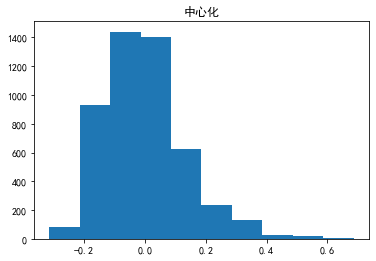

In [2]:
# 中心化代码
def Normalization_fun(x):
    # 特征零均值
    x = (x - np.mean(x, 0)) / (np.max(x, 0) - np.min(x, 0))
    return x

# 提取特征和标签
X = data.iloc[:, 0:-1]  # N D
X = Normalization_fun(X)
Y = data.iloc[:, -1]
print("前0-10列为特征,X:",X.shape)
print("最后一列为标签,Y:",Y.shape)
# 可视化中心化后的sulphates特征
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.hist(X["sulphates"])
plt.title("中心化")
plt.show()

In [3]:
# 这里注意一个小trick：回归系数会比特征x多一维，为了向量相乘方便，可以在训练集X左侧添加全为1的一列
data0 = pd.concat([pd.DataFrame(np.ones(X.shape[0]), columns=['x0']), X], axis=1)
data0

,x0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.013963,-0.008080,0.015547,0.219457,-0.002292,0.033770,0.073409,0.134425,-0.171151,-0.046334,-0.276495
1,1.0,-0.053345,0.021332,0.003499,-0.073488,0.009578,-0.074244,-0.014758,-0.000528,0.101576,0.000178,-0.163591
2,1.0,0.119732,0.001724,0.039644,0.007800,0.012545,-0.018495,-0.095964,0.020679,0.065212,-0.057961,-0.066817
3,1.0,0.033193,-0.047295,-0.008549,0.032340,0.036284,0.040738,0.110532,0.030319,0.001576,-0.104473,-0.099075
4,1.0,0.033193,-0.047295,-0.008549,0.032340,0.036284,0.040738,0.110532,0.030319,0.001576,-0.104473,-0.099075
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,1.0,-0.062960,-0.066903,-0.026621,-0.073488,-0.020096,-0.039401,-0.107565,-0.055666,0.074303,0.011806,0.110602
4894,1.0,-0.024499,0.040940,0.015547,0.024672,0.003643,0.075582,0.068769,0.016823,-0.034788,-0.034706,-0.147462
4895,1.0,-0.034114,-0.037491,-0.086862,-0.079623,-0.014161,-0.018495,-0.063482,-0.028675,-0.180242,-0.034706,-0.179720
4896,1.0,-0.130268,0.011528,-0.020597,-0.081157,-0.070541,-0.053338,-0.065802,-0.102899,0.137939,-0.127729,0.368667


In [4]:
# 初始化回归系数
W_init = np.random.randn(data0.shape[1], 1)
W_init.shape

(12, 1)

# 分层采样划分训练集和测试集

In [30]:
#sklearn中分层采样
from sklearn.model_selection import StratifiedShuffleSplit
type=set(Y)
print("标签种类：",type)
#设定4：1，划分训练集和测试集
#总共循环1次
data0=np.array(data0)#转个格式
mysplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in mysplit.split(data0, Y):
    X_train, X_test = data0[train_index], data0[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    print("X:",X_train.shape,X_test.shape)
    print("y:",y_train.shape,y_test.shape)

标签种类： {3, 4, 5, 6, 7, 8, 9}
X: (3918, 12) (980, 12)
y: (3918,) (980,)


# 批量梯度下降（矩阵运算并行加速）

$$\theta_{j}=\theta_{j}+\alpha \frac{1}{m}(y-X \theta)^{T} x_{j} $$

$$
\Delta_{\theta} \operatorname{MSE}(\theta) = \left(\begin{array}{c}
\frac{\partial}{\partial \theta_{0}} \operatorname{MSE}(\theta) \\
\frac{\partial}{\partial \theta_{1}} \operatorname{MSE}(\theta) \\
\vdots \\
\frac{\partial}{\partial \theta_{\mathrm{n}}} \operatorname{MSE}(\theta)
\end{array}\right) = \frac{1}{\mathrm{~m}} \mathbf{X}^{\mathrm{T}}(\mathbf{X} \cdot \theta-\mathbf{y})
$$

$$\text { Loss }=\frac{1}{N} \sum_{i=1}^{N}\left(y^{(i)}-f\left(\boldsymbol{x}^{(i)}, \boldsymbol{\theta}\right)\right)^{2}$$

In [196]:
#定义均方差MSE
def MSE(predict, true):
    return 1/predict.shape[0]*np.sum((predict - true)**2)
MSE_train=[]
iteration_train=[]
MSE_test=[]
iteration_test=[]

#批量梯度下降
alpha = 0.1   # 学习率
n_iterations = 1000 #迭代次数
m = X_train.shape[0]
theta=W_init.flatten()#theta为系数向量
print(theta.shape)
for iteration in range(n_iterations):
    gradients = 1/m * X_train.T.dot(X_train.dot(theta) - y_train)#损失函数
    theta = theta - alpha * gradients
    if iteration<50:
        #训练集的MSE
        predict=X_train.dot(theta)
        MSE_train.append(MSE(predict,y_train))
        iteration_train.append(iteration)
        #测试的MSE
        test_predict=X_test.dot(theta)
        MSE_test.append(MSE(test_predict,y_test))
        iteration_test.append(iteration)
print("最终theta:",theta)
print("训练集MSE：",MSE(X_train.dot(theta),y_train))
print("测试集MSE：",MSE(X_test.dot(theta),y_test))

(12,)
最终theta: [ 5.87895295 -0.17086267 -1.18216085  0.27663199  1.18786157 -0.13465647
 -0.06152687  0.28971208 -0.6294669   0.32547966  0.29943501  1.99610451]
训练集MSE： 0.5930856762120191
测试集MSE： 0.557303834173734


## 绘图MSE收敛曲线

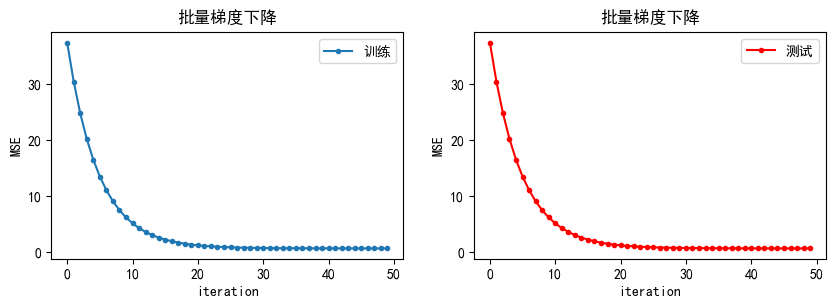

In [197]:
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(10,3),dpi=100)

plt.subplot(1,2,1)
plt.rc('font', family='SimHei', size=10)
plt.plot(iteration_train,MSE_train,marker='o',markersize=3)
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.legend(['训练'])  # 设置折线名称
plt.title('批量梯度下降')

plt.subplot(1,2,2)
plt.rc('font', family='SimHei', size=10)
plt.plot(iteration_test,MSE_test,color='r',marker='o',markersize=3)
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.legend(['测试'])  # 设置折线名称
plt.title('批量梯度下降')
plt.show() 

可以看出训练集和测试集，通过迭代次数的增加，其MSE均方误差的收敛趋势是一致的，模型应该是正确的。在迭代50次后，MSE趋近于极限。
即：

训练集MSE： 0.6124910958661429

测试集MSE： 0.5768161696411216

## 探究最佳学习率（迭代1000次）

测试函数：0.557304 结果正确
[0.6374682957886199, 0.5915468110045909, 0.557303834173734, 0.5482036275009625, 0.5490687852336439]


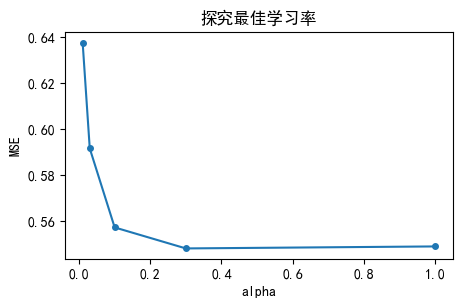

In [183]:
def alpha_chooseBGD(alpha):
    #alpha = 学习率
    n_iterations = 1000
    m = X_train.shape[0]
    theta=W_init.flatten()#theta为系数向量
    for iteration in range(n_iterations):
        gradients = 1/m * X_train.T.dot(X_train.dot(theta) - y_train)#损失函数
        theta = theta - alpha * gradients
        #测试的MSE
    test_predict=X_test.dot(theta)
    return MSE(test_predict,y_test)
print("测试函数：%f 结果正确"%alpha_chooseBGD(0.1))

#手动规定测试的学习率
alpha_list=[0.01,0.03,0.1,0.3,1]
score_MSE=[]
for test in alpha_list:
    score_MSE.append(alpha_chooseBGD(test))
print(score_MSE)

#绘图
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(alpha_list,score_MSE,marker='o',markersize=4)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('探究最佳学习率')
plt.show() 

可以看出，在人为设定$n\_iterations = 1000$迭代1000次，当学习率取值为0.01,0.03,0.1,0.3,1时，$\alpha=0.3$时，MSE（均方误差最小）

# 随机梯度下降

$$
\text{重复直到收敛 ( Repeat until convergence ):}\\
\text { for } i=1 \text { to } m \text { : }\\
\theta_{j} = \theta_{j}+\alpha\left(y^{(i)}-h_{\theta}\left(x^{(i)}\right)\right) x_{j}^{(i)}
$$

In [149]:
MSE_train=[]
iteration_train=[]
MSE_test=[]
iteration_test=[]

#随机梯度下降
alpha = 0.1   # 学习率
n_iterations = 50
theta=W_init.flatten()#theta为系数向量
for iteration in range(n_iterations):
    for i in range(X_train.shape[0]):
        erro= X_train[i].dot(theta.T)-y_train[i:i+1]
        for j in range(theta.shape[0]):
            theta[j] = theta[j] - alpha*erro*X_train[i,j]
    #print(theta)
    #训练集的MSE
    predict=X_train.dot(theta)
    MSE_train.append(MSE(predict,y_train))
    iteration_train.append(iteration)
    #测试的MSE
    test_predict=X_test.dot(theta)
    MSE_test.append(MSE(test_predict,y_test))
    iteration_test.append(iteration)

## 绘制MSE收敛曲线

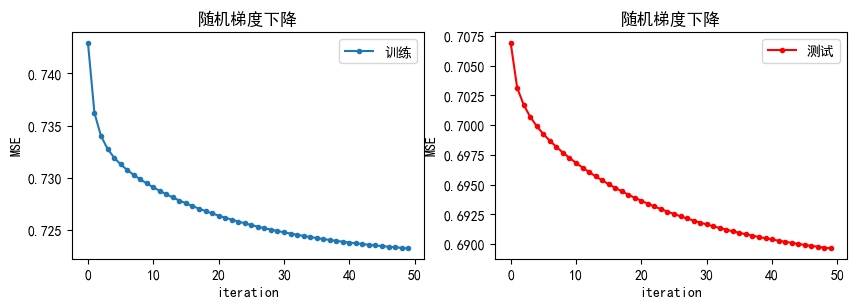

In [185]:
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(10,3),dpi=100)

plt.subplot(1,2,1)
plt.rc('font', family='SimHei', size=10)
plt.plot(iteration_train,MSE_train,marker='o',markersize=3)
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.legend(['训练'])  # 设置折线名称
plt.title('随机梯度下降')

plt.subplot(1,2,2)
plt.rc('font', family='SimHei', size=10)
plt.plot(iteration_test,MSE_test,color='r',marker='o',markersize=3)
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.legend(['测试'])  # 设置折线名称
plt.title('随机梯度下降')
plt.show() 

可以看出，随机梯度下降比批量随机下降更快的接近MSE的极限，符合理论实际

## 探究最佳学习率（迭代50次）
因为随机梯度下降可以更快的接近MSE的极限

测试函数：0.689789 结果正确
[0.5494853884048913, 0.5491932323635575, 0.5521981227540994, 0.5626975901449294, 0.6897887805325553]


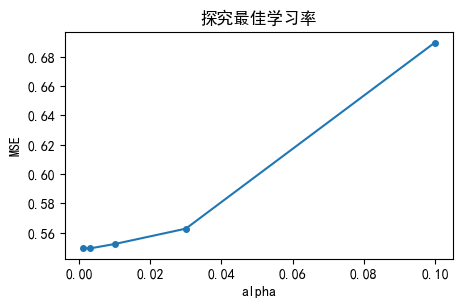

In [195]:
def alpha_chooseSDG(alpha):
    n_iterations = 50
    theta=W_init.flatten()#theta为系数向量
    for iteration in range(n_iterations):
        for i in range(X_train.shape[0]):
            erro= X_train[i].dot(theta.T)-y_train[i:i+1]
            for j in range(theta.shape[0]):
                theta[j] = theta[j] - alpha*erro*X_train[i,j]
            
    #测试的MSE
    test_predict=X_test.dot(theta)
    return MSE(test_predict,y_test)
print("测试函数：%f 结果正确"%alpha_chooseSDG(0.1))

#手动规定测试的学习率
alpha_list=[0.001,0.003,0.01,0.03,0.1]
score_MSE=[]
for test in alpha_list:
    score_MSE.append(alpha_chooseSDG(test))
print(score_MSE)

#绘图
from matplotlib import pyplot as plt
#设置画布大小像素点
plt.figure(figsize=(5,3),dpi=100)
plt.rc('font', family='SimHei', size=10)
plt.plot(alpha_list,score_MSE,marker='o',markersize=4)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('探究最佳学习率')
plt.show() 

可以看出，在人为设定$n\_iterations = 50$迭代50次，当学习率取值为0.001,0.003,0.01,0.03,0.1时，$\alpha=0.03$时，MSE（均方误差最小）

# 回归模型在机器学习和统计学上的差异

我认为机器学习和统计学的主要差异在于：**两者的目的不同，机器学习主要是用于预测，可能具有不可解释性；而统计学的主要目的为从数学的角度去求解变量之间的关系，极具逻辑性和解释性。**

以本次的回归模型为例：

**机器学习：**不论使用批量梯度下降还是随机梯度下降，都需要对初始化后的数据进行训练集和测试集的划分。在训练集中通过定义损失函数(loss),从而进行 参数调整。而训练得到的模型究竟表现如何需要通过数据的另一个子集测试集测试之后才能知道。我们为了在测试集上取得的分数最高，不断炼丹，实际上是对最佳解的不断逼近。

**统计学：**统计学的目的是为了解出输入X（向量）和输出（Y）之间的函数关系，例如，在本实验的过程中，统计学不需要划分训练集和测试集，而是需要通过建模，计算各个自变量和因变量之间的函数关系，主要研究的是通过矩阵运算得出的严谨的数学关系，而不是对测试集数据进行预测。其目的，是为了让建立的数学模型具有更高的准确性、鲁棒性。

机器学习的目的是获得一个可反复预测的模型。我们通常不关心模型是否可以解释，机器学习只在乎结果。而统计建模更多的是为了寻找变量之间的关系和确定关系的显著性，恰巧迎合了预测。

**但是两者依然存在共通的地方：**

在实现岭回归模型时，我使用的为解析法，并非像传统的批量梯度下降和随机梯度下降需要每一步都计算损失函数(loss),再用其调整$w$参数，我们通过统计学确立的数学模型，直接求解出最佳$w$。（PS：虽然仍然需要放到测试集合上测试，但是深深地体现出了统计学知识。）

# 岭回归（解析法）

损失函数：岭回归模型的目标函数在线性模型的基础上加了$L2$范数的惩罚项：

\begin{array}{c}
\text { Loss } = \frac{1}{2 N} \sum_{i = 1}^{N}\left(y^{(i)}-f\left(\boldsymbol{x}^{(i)}, \boldsymbol{\theta}\right)\right)^{2}+\lambda \sum_{j = 0}^{N} \theta_{j}^{2}
\end{array}

对$\theta$求偏导，当偏导数为$0$时，损失函数最小，所以岭回归的解为：

\begin{align}
\text{ 岭回归求解 :}\mathrm{w} & = (X^{T} X+\underset{ }{\lambda I)^{-1} X^{T} \mathrm{y}}\\
\lambda & = \text{岭系数}\\
I&= \text{单位矩阵}\\
\end{align}

In [43]:
#岭回归,岭系数=0.1
def myRidge(X,y,lamda=0.1):
    XTX=X.T.dot(X)
    #np.eye()生成单位矩阵
    I=np.eye(X.shape[1])
    #括号内矩阵
    bracket=XTX+lamda*I
    #np.linalg.pinv()求伪逆
    return np.linalg.pinv(bracket).dot(X.T).dot(y)

#计算平均误差
def avgerro(predict,y):
    sum=0
    for i in range (len(y)):
        sum+=abs(predict[i]-y[i])
    return sum/len(y)

print("岭回归系数：",myRidge(X_train,y_train))

岭回归系数： [ 5.87985018  0.50812708 -1.96449827 -0.16661463  4.42796223 -0.20025861
  1.21785537 -0.28070175 -5.77549582  0.5687612   0.55937318  1.42589258]


## 模型评估

In [46]:
Ridge_theta=myRidge(X_train,y_train)
#训练预测
myRidge_train=X_train.dot(Ridge_theta)
print("岭回归训练平均误差：",avgerro(myRidge_train,y_train.tolist()))
#测试预测
myRidge_test=X_test.dot(Ridge_theta)
print("岭回归测试平均误差：",avgerro(myRidge_test,y_test.tolist()))

岭回归训练平均误差： 0.5878184788835739
岭回归测试平均误差： 0.5672847535302716
